# 6.6 Convolutional Neural Networks (LeNet)
We now have all the ingredients required to assemble a fully-functional CNN. In our earlier encounter with image data, we applied a softmax regression model (Section 3.6) and an MLP model
(Section 4.2) to pictures of clothing in the Fashion-MNIST dataset. To make such data amenable
to softmax regression and MLPs, we first flattened each image from a 28 × 28 matrix into a fixedlength 784-dimensional vector, and thereafter processed them with fully-connected layers. Now
that we have a handle on convolutional layers, we can retain the spatial structure in our images. As
an additional benefit of replacing fully-connected layers with convolutional layers, we will enjoy
more parsimonious models that require far fewer parameters.

In this section, we will introduce LeNet, among the first published CNNs to capture wide attention
for its performance on computer vision tasks. The model was introduced by (and named for) Yann
LeCun, then a researcher at AT&T Bell Labs, for the purpose of recognizing handwritten digits
in images (LeCun et al., 1998). This work represented the culmination of a decade of research
developing the technology. In 1989, LeCun published the first study to successfully train CNNs via
backpropagation.

At the time LeNet achieved outstanding results matching the performance of support vector machines, then a dominant approach in supervised learning. LeNet was eventually adapted to recognize digits for processing deposits in ATM machines. To this day, some ATMs still run the code
that Yann and his colleague Leon Bottou wrote in the 1990s!

## 6.6.1 LeNet
At a high level, LeNet (LeNet-5) consists of two parts: (i) a convolutional encoder consisting of
two convolutional layers; and (ii) a dense block consisting of three fully-connected layers; The
architecture is summarized in Fig. 6.6.1.

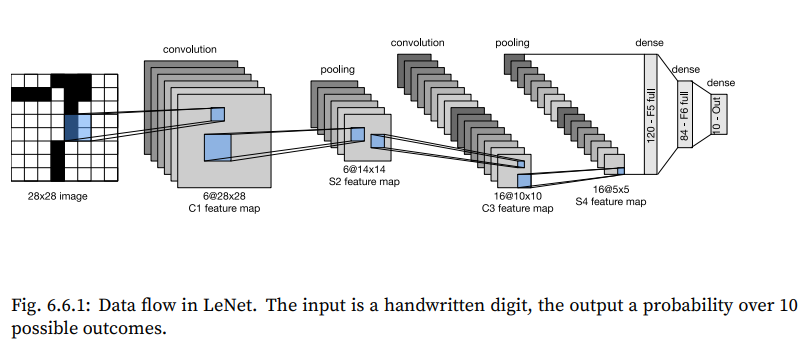

e basic units in each convolutional block are a convolutional layer, a sigmoid activation function, and a subsequent average pooling operation. Note that while ReLUs and max-pooling work
better, these discoveries had not yet been made in the 1990s. Each convolutional layer uses a $5×5$
kernel and a sigmoid activation function. These layers map spatially arranged inputs to a number of two-dimensional feature maps, typically increasing the number of channels. The first convolutional layer has 6 output channels, while the second has 16. Each $2×2$ pooling operation (stride 2)
reduces dimensionality by a factor of 4 via spatial downsampling. The convolutional block emits
an output with shape given by (batch size, number of channel, height, width).

In order to pass output from the convolutional block to the dense block, we must flatten each
example in the minibatch. In other words, we take this four-dimensional input and transform
it into the two-dimensional input expected by fully-connected layers: as a reminder, the two-dimensional representation that we desire has uses the first dimension to index examples in the
minibatch and the second to give the flat vector representation of each example. LeNetʼs dense
block has three fully-connected layers, with 120, 84, and 10 outputs, respectively. Because we
are still performing classification, the 10-dimensional output layer corresponds to the number of
possible output classes.

While getting to the point where you truly understand what is going on inside LeNet may have
taken a bit of work, hopefully the following code snippet will convince you that implementing such
models with modern deep learning frameworks is remarkably simple. We need only to instantiate
a Sequential block and chain together the appropriate layers.

In [1]:
use strict;
use warnings;
use Data::Dump qw(dump);
use AI::MXNet qw(mx);
use AI::MXNet::Gluon qw(gluon);
use List::Util qw(min max shuffle);
use d2l;
use d2l::Accumulator;
use d2l::Animator;

In [2]:
my $net = gluon->nn->Sequential();
$net->name_scope(sub {
    $net->add(gluon->nn->Conv2D(channels=>6, kernel_size=>5, padding=>2, activation=>'sigmoid', in_channels=>1 ));
    $net->add(gluon->nn->AvgPool2D(pool_size=>2, strides=>2));
    $net->add(gluon->nn->Conv2D(channels=>16, kernel_size=>5, activation=>'sigmoid', in_channels=>6));
    $net->add(gluon->nn->AvgPool2D(pool_size=>2, strides=>2));
    # `Dense` will transform an input of the shape (batch size, number of
    # channels, height, width) into an input of the shape (batch size,
    # number of channels * height * width) automatically by default
    $net->add(gluon->nn->Dense(units=>120, activation=>'sigmoid', in_units=>400));
    $net->add(gluon->nn->Dense(units=>84, activation=>'sigmoid', in_units=>120));
    $net->add(gluon->nn->Dense(units=>10, in_units=>84));
});
$net;

Sequential(
  (0): Conv2D(1 -> 6, kernel_size=(5,5), stride=(1,1), padding=(2,2))
  (1): AvgPool2D(size=(2,2), stride=(2,2), padding=(0,0), ceil_mode=0)
  (2): Conv2D(6 -> 16, kernel_size=(5,5), stride=(1,1))
  (3): AvgPool2D(size=(2,2), stride=(2,2), padding=(0,0), ceil_mode=0)
  (4): Dense(120 -> 400, Activation(sigmoid))
  (5): Dense(84 -> 120, Activation(sigmoid))
  (6): Dense(10 -> 84, linear)
)

We took a small liberty with the original model, removing the Gaussian activation in the final
layer. Other than that, this network matches the original LeNet-5 architecture.

By passing a single-channel (black and white) $28×28$ image through the network and printing the
output shape at each layer, we can inspect the model to make sure that its operations line up with
what we expect from Fig. 6.6.2.

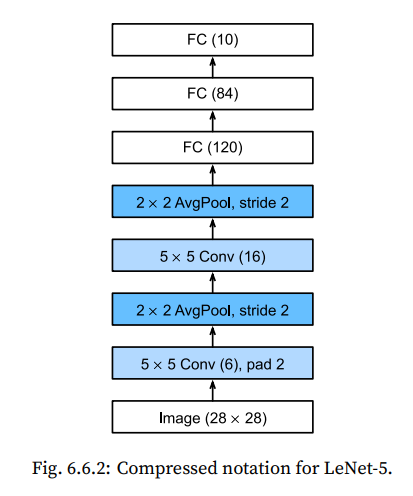

In [3]:
my $X = mx->nd->random->uniform(shape=>[1, 1, 28, 28]);
$net->initialize(mx->init->Xavier(), force_reinit=>1);

In [4]:
my $i = 0;
while(defined($net->[$i]) == 1){
    if($net->[$i]->units){
        print($net->[$i]->name . ' output shape: '. $net->[$i]->units . "\n");
    }elsif($net->[$i]->channels){
        print($net->[$i]->name . ' output channels: '. $net->[$i]->channels . "\n");
    }
    $i = $i+1;
}

sequential0_conv0 output channels: 6
sequential0_conv1 output channels: 16
sequential0_dense0 output shape: 120
sequential0_dense1 output shape: 84
sequential0_dense2 output shape: 10


Note that the height and width of the representation at each layer throughout the convolutional
block is reduced (compared with the previous layer). The first convolutional layer uses 2 pixels of
padding to compensate for the reduction in height and width that would otherwise result from using a $5×5$ kernel. In contrast, the second convolutional layer forgoes padding, and thus the height
and width are both reduced by 4 pixels. As we go up the stack of layers, the number of channels
increases layer-over-layer from 1 in the input to 6 after the first convolutional layer and 16 after
the second convolutional layer. However, each pooling layer halves the height and width. Finally,
each fully-connected layer reduces dimensionality, finally emitting an output whose dimension
matches the number of classes.

## 6.6.2 Training
Now that we have implemented the model, let us run an experiment to see how LeNet fares on
Fashion-MNIST

In [5]:
sub load_array{
    my ($X, $y, $batch_size, $is_train) = @_;
    my $dataset = gluon->data->ArrayDataset(data=>$X, label=>$y);
    return gluon->data->DataLoader($dataset, batch_size=> $batch_size, shuffle=>$is_train);
}

In [6]:
sub data_iter_sequential{ # Optimized for sequential minibatches
  my ($features, $labels, $batch_size) = @_;
  my $num_samples = $features->len;
  my @indices = (0 .. $num_samples - 1);
  my ($index, @batch_indices) = 0;

  return sub {
    if (defined $_[0] && $_[0] == 0){# Reset
      $index = 0;
      return 1;
    }
    return undef if ($index >= $num_samples);
    @batch_indices = @indices[$index .. min($index + $batch_size, $num_samples) - 1];
    $index += $batch_size;
    return {data  => $features->slice([$batch_indices[0], $batch_indices[-1]]), 
            label => $labels->slice([$batch_indices[0], $batch_indices[-1]])};
  };
}

In [7]:
my $batch_size = 256;
my $data_train = gluon->data->vision->FashionMNIST('~/.mxnet/datasets/fashion-mnist', train => 1);
my $data_test  = gluon->data->vision->FashionMNIST('~/.mxnet/datasets/fashion-mnist',  train => 0);


AI::MXNet::Gluon::Data::Vision::DownloadedDataSet::FashionMNIST=HASH(0xb095940)

In [8]:
my $transform = sub {my ($data, $label) = @_;                 
                       return ($data->reshape([$data->shape->[0], 1, 28, 28])->astype('float32') / 255, $label)};
                       
my $inverse_transform = sub {my ($data, $label) = @_;                 
                       return (($data->reshape([$data->shape->[0], 28, 28, 1] ) * 255)->astype('int32'), $label)};

CODE(0xaf66af0)

In [9]:
my ($X_train, $y_train) = $transform->($data_train->{data}, mx->nd->array($data_train->{label}));
my ($X_test, $y_test)   = $transform->($data_test->{data} , mx->nd->array($data_test->{label}));

<AI::MXNet::NDArray 10000x1x28x28 @cpu(0)><AI::MXNet::NDArray 10000 @cpu(0)>

In [10]:
my ($X_train_inv, $y_train_inv) = $inverse_transform->($X_train, $y_train);

<AI::MXNet::NDArray 60000x28x28x1 @cpu(0)><AI::MXNet::NDArray 60000 @cpu(0)>

In [11]:
print dump $X_train->shape

[60000, 1, 28, 28]

1

In [12]:
my $train_iter = data_iter_sequential($X_train, $y_train, $batch_size);
my $test_iter  = data_iter_sequential($X_test, $y_test, $batch_size);

CODE(0xb4af760)

In [13]:
$train_iter->(0);

1

In [14]:
print dump $train_iter->()->{data}->shape;
# print dump $X_train->shape

[256, 1, 28, 28]

1

While CNNs have fewer parameters, they can still be more expensive to compute than similarly
deep MLPs because each parameter participates in many more multiplications. If you have access
to a GPU, this might be a good time to put it into action to speed up training.

For evaluation, we need to make a slight modification to the evaluate_accuracy function that we
described in Section 3.6. Since the full dataset is in the main memory, we need to copy it to the
GPU memory before the model uses GPU to compute with the dataset.

In [15]:
sub evaluate_accuracy_gpu{ #@save
    #"""Compute the accuracy for a model on a dataset using a GPU."""
    my ($net, $data_iter, $device) = @_;
    $data_iter->(0);
    # Query the first device where the first parameter is on
    # No. of correct predictions, no. of predictions
    my $metric = Accumulator->new(2);
        while (defined(my $batch = $data_iter->())){
            my $data = $batch->{data};
            my $label = $batch->{label}->astype('float32'); 
            my ($X, $y) = ($data->as_in_context($device), $label->as_in_context($device));

            $metric->add([ d2l->accuracy($net->($X), $y), $y->size]);
        }
            
    if($metric->getitem(1)==0){
        return (0);
    }else{
        return ($metric->getitem(0) / $metric->getitem(1));
    }
}


We also need to update our training function to deal with GPUs. Unlike the train_epoch_ch3 defined in Section 3.6, we now need to move each minibatch of data to our designated device (hopefully, the GPU) prior to making the forward and backward propagations.

The training function train_ch6 is also similar to train_ch3 defined in Section 3.6. Since we will
be implementing networks with many layers going forward, we will rely primarily on high-level
APIs. The following training function assumes a model created from high-level APIs as input and
is optimized accordingly. We initialize the model parameters on the device indicated by the device
argument, using Xavier initialization as introduced in Section 4.8.2. Just as with MLPs, our loss
function is cross-entropy, and we minimize it via minibatch stochastic gradient descent. Since
each epoch takes tens of seconds to run, we visualize the training loss more frequently.

In [16]:
# print $net->iddnitialize(mx->)
$train_iter->(0);
my $num_batches = 0;
while (defined(my $batch = $train_iter->())){
    $num_batches++;
}

print $num_batches;

235

1

In [17]:
#@save
sub train_ch6{
    #"""Train a model with a GPU (defined in Chapter 6)."""
    my ($net, $train_iter, $test_iter, $num_epochs, $lr, $device, $batch_size, $num_batches) = @_;
    $net->initialize(mx->init->Xavier(), ctx=>$device, force_reinit=>1);
    my $loss = gluon->loss->SoftmaxCrossEntropyLoss();
    my $trainer = gluon->Trainer($net->collect_params(), 'sgd',{learning_rate=> $lr});
    my $animator = Animator->new(xlabel=>'epoch', xlim=>[1, $num_epochs], legend=>['train loss', 'train acc', 'test acc']);
    my $sum_interval = 0;
    
    my ($train_l, $train_acc, $test_acc, $time_start, $time_end) = (0,0,0,0,0);
    my $metric = Accumulator->new(3);

    for my $epoch (0..$num_epochs-1){
        # Sum of training loss, sum of training accuracy, no. of examples
        $trainer->step($batch_size, 1);
        my $i = 0;
        my ($y_hat, $l);
        $train_iter->(0);
        while (defined(my $batch = $train_iter->())){
            my $data = $batch->{data};
            my $label = $batch->{label}->astype('float32'); 
            
            $time_start = time();
            # Here is the major difference from `d2l.train_epoch_ch3`
            my ($X, $y) = ($data->as_in_context($device), $label->as_in_context($device));
            
            mx->autograd->record(sub {
                $y_hat = $net->($X);
                $l = $loss->($y_hat, $y);
            });
            $l->backward();
            
            $trainer->step($X->shape->[0]);

            $metric->add([$l->sum()->asarray->[0], d2l->accuracy($y_hat, $y), $X->shape->[0]]);

            $time_end = time();
            $sum_interval = $sum_interval + $time_end - $time_start;
            
            $train_l = $metric->getitem(0) / $metric->getitem(2);
            $train_acc = $metric->getitem(1) / $metric->getitem(2);
            if ( (($i + 1) % (($num_batches-$num_batches%5)/5) == 0) || ($i == $num_batches - 1) ){
                $animator->add($epoch + ($i + 1) / $num_batches, [$train_l, $train_acc, undef])
            }
            $i++;
        }
        $test_acc = evaluate_accuracy_gpu($net, $test_iter, $device);
        $animator->add($epoch + 1, [undef, undef, $test_acc]);
    }
    print('loss ' . $train_l . ', train acc ' . $train_acc . ', test acc ' . $test_acc . "\n" );
    print( ($metric->getitem(2) * $num_epochs / $sum_interval) . ' examples/sec on ' . $device ."\n");
    
    return $animator;  
} 

Now let us train and evaluate the LeNet-5 model.

In [18]:
my ($lr, $num_epochs) = (0.9, 10);
my $animator = train_ch6($net, $train_iter, $test_iter, $num_epochs, $lr, d2l->try_gpu(), $batch_size, $num_batches);

loss 0.653785006510417, train acc 0.748793333333333, test acc 0.846
11173.1843575419 examples/sec on cpu(0)


Animator=HASH(0xb086360)

In [19]:
IPerl->load_plugin('Chart::Plotly');
use Chart::Plotly::Trace::Scatter;
$animator->plot

## Summary
* A CNN is a network that employs convolutional layers.
* In a CNN, we interleave convolutions, nonlinearities, and (often) pooling operations.
* In a CNN, convolutional layers are typically arranged so that they gradually decrease the spatial resolution of the representations, while increasing the number of channels.
* In traditional CNNs, the representations encoded by the convolutional blocks are processed by one or more fully-connected layers prior to emitting output.
* LeNet was arguably the first successful deployment of such a network.